In [ ]:
if hasattr(model, "feature_names_in_"):
    print("\nModel B feature names:", model.feature_names_in_)
else:
    print("\nFeature names used in training:", list(X_train.columns))


Model B feature names: ['gravida' 'parity' 'gestational age (weeks)' 'Age (yrs)' 'BMI  [kg/m²]'
 'diabetes' 'History of hypertension (y/n)' 'Systolic BP' 'Diastolic BP'
 'HB' 'fetal weight(kgs)' 'Protien Uria' 'amniotic fluid levels(cm)']


Train shape: (162, 17)
Test shape: (41, 17)
Fitting 3 folds for each of 162 candidates, totalling 486 fits

✅ Best Parameters Found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200}

🎯 Final Model Accuracy: 95.12%

Classification Report:
               precision    recall  f1-score   support

        high       0.71      1.00      0.83         5
         low       1.00      1.00      1.00        25
         mid       1.00      0.82      0.90        11

    accuracy                           0.95        41
   macro avg       0.90      0.94      0.91        41
weighted avg       0.97      0.95      0.95        41


Confusion Matrix:
 [[ 5  0  0]
 [ 0 25  0]
 [ 2  0  9]]


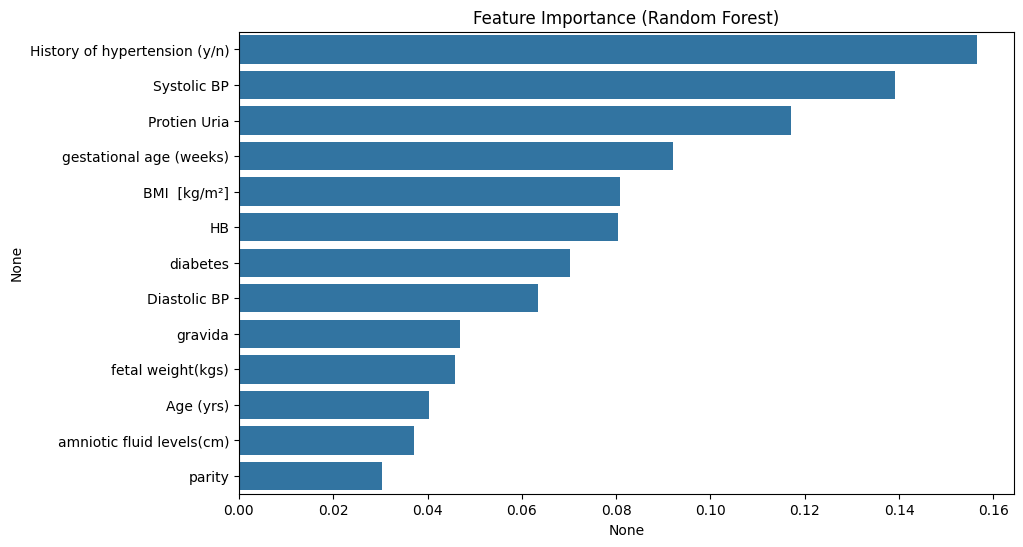


✅ Saved:
  artifacts/model_b_rf.joblib
  artifacts/scaler_model_b.joblib
  artifacts/label_encoder_model_b.joblib
  artifacts/feature_names_model_b.joblib


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# -------------------------------
# Load Data
# -------------------------------
train_data = pd.read_excel("data/train_dataset.xlsx")
test_data = pd.read_excel("data/test_dataset.xlsx")

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

# -------------------------------
# Clean Columns
# -------------------------------
cols_to_drop = [
    "Unnamed: 12",
    "Uterine Artery Doppler Resistance Index (RI)",
    " Uterine Artery Doppler Pulsatility Index (PI"
]
train_data.drop(columns=[c for c in cols_to_drop if c in train_data.columns], inplace=True)
test_data.drop(columns=[c for c in cols_to_drop if c in test_data.columns], inplace=True)

# -------------------------------
# Handle Missing Values
# -------------------------------
train_data.fillna(train_data.mean(numeric_only=True), inplace=True)
test_data.fillna(test_data.mean(numeric_only=True), inplace=True)

# -------------------------------
# Clean Target Column
# -------------------------------
train_data["Risk_level"] = train_data["Risk_level"].str.strip().str.lower()
test_data["Risk_level"] = test_data["Risk_level"].str.strip().str.lower()

# -------------------------------
# Split Features and Target
# -------------------------------
X_train = train_data.drop(columns=["Risk_level"])
y_train = train_data["Risk_level"]
X_test = test_data.drop(columns=["Risk_level"])
y_test = test_data["Risk_level"]

# -------------------------------
# Save Feature Names (before scaling)
# -------------------------------
feature_names = X_train.columns.tolist()

# -------------------------------
# Label Encode Target
# -------------------------------
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# -------------------------------
# Feature Scaling
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Balance Data (SMOTE)
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# -------------------------------
# Grid Search for Best Parameters
# -------------------------------
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [10, 15, 20],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 3],
    "bootstrap": [True, False]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)

print("\n✅ Best Parameters Found:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# -------------------------------
# Train Best Model
# -------------------------------
best_rf.fit(X_train_res, y_train_res)

# -------------------------------
# Evaluation
# -------------------------------
y_pred = best_rf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Final Model Accuracy: {acc*100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -------------------------------
# Feature Importance
# -------------------------------
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

# -------------------------------
# Save Model Artifacts
# -------------------------------
os.makedirs("artifacts", exist_ok=True)

joblib.dump(best_rf, "artifacts/model_b_rf.joblib")
joblib.dump(scaler, "artifacts/scaler_model_b.joblib")
joblib.dump(label_encoder, "artifacts/label_encoder_model_b.joblib")
joblib.dump(feature_names, "artifacts/feature_names_model_b.joblib")

print("\n✅ Saved:")
print("  artifacts/model_b_rf.joblib")
print("  artifacts/scaler_model_b.joblib")
print("  artifacts/label_encoder_model_b.joblib")
print("  artifacts/feature_names_model_b.joblib")


In [ ]:
import joblib

feature_names = joblib.load("artifacts/feature_names_model_b.joblib")
print("✅ Model B feature names used during training:\n", feature_names)


✅ Model B feature names used during training:
 ['gravida', 'parity', 'gestational age (weeks)', 'Age (yrs)', 'BMI  [kg/m²]', 'diabetes', 'History of hypertension (y/n)', 'Systolic BP', 'Diastolic BP', 'HB', 'fetal weight(kgs)', 'Protien Uria', 'amniotic fluid levels(cm)']


In [ ]:
# Create some dummy unseen data (ensure column order matches training data)
# Example data based on the feature names:
# ['gravida', 'parity', 'gestational age (weeks)', 'Age (yrs)', 'BMI  [kg/m²]',
# 'diabetes', 'History of hypertension (y/n)', 'Systolic BP', 'Diastolic BP',
# 'HB', 'fetal weight(kgs)', 'Protien Uria', 'amniotic fluid levels(cm)']

dummy_unseen_data = pd.DataFrame([
    [2, 1, 35.0, 28, 25.0, 0, 0, 120, 80, 12.0, 3.0, 0, 11.0],  # Low Risk-like
    [5, 3, 28.0, 35, 30.0, 1, 1, 160, 100, 9.0, 2.0, 1, 8.0],   # High Risk-like
    [1, 0, 40.0, 22, 22.0, 0, 0, 110, 70, 13.0, 3.5, 0, 14.0],  # Low Risk-like
    [3, 2, 32.0, 30, 27.0, 0, 1, 140, 90, 10.0, 2.5, 0, 10.0],   # Mid Risk-like
    [7, 4, 25.0, 40, 35.0, 1, 1, 180, 110, 8.0, 1.5, 1, 7.0]    # High Risk-like (more extreme)
], columns=['gravida', 'parity', 'gestational age (weeks)', 'Age (yrs)', 'BMI  [kg/m²]',
            'diabetes', 'History of hypertension (y/n)', 'Systolic BP', 'Diastolic BP',
            'HB', 'fetal weight(kgs)', 'Protien Uria', 'amniotic fluid levels(cm)'])

print("Dummy Unseen Data:")
display(dummy_unseen_data)

Dummy Unseen Data:


,gravida,parity,gestational age (weeks),Age (yrs),BMI [kg/m²],diabetes,History of hypertension (y/n),Systolic BP,Diastolic BP,HB,fetal weight(kgs),Protien Uria,amniotic fluid levels(cm)
0,2,1,35.0,28,25.0,0,0,120,80,12.0,3.0,0,11.0
1,5,3,28.0,35,30.0,1,1,160,100,9.0,2.0,1,8.0
2,1,0,40.0,22,22.0,0,0,110,70,13.0,3.5,0,14.0
3,3,2,32.0,30,27.0,0,1,140,90,10.0,2.5,0,10.0
4,7,4,25.0,40,35.0,1,1,180,110,8.0,1.5,1,7.0


In [ ]:
import joblib
import os
import pandas as pd

# Load the saved scaler and label encoder
try:
    loaded_scaler = joblib.load("artifacts/scaler_model_b.joblib")
    loaded_label_encoder = joblib.load("artifacts/label_encoder_model_b.joblib")
    loaded_model = joblib.load("artifacts/model_b_rf.joblib")
    print("✅ Loaded scaler, label encoder, and model from artifacts.")
except FileNotFoundError:
    print("❌ Error: Artifacts not found. Please run the model training and saving steps first.")

✅ Loaded scaler, label encoder, and model from artifacts.


In [ ]:
# Ensure the dummy data has the same columns and order as the training data
# (This step is important for consistent scaling and prediction)
# Assuming 'feature_names' was saved during training and loaded
try:
    loaded_feature_names = joblib.load("artifacts/feature_names_model_b.joblib")
    dummy_unseen_data_ordered = dummy_unseen_data[loaded_feature_names]
except FileNotFoundError:
     print("❌ Error: Feature names artifact not found. Ensure 'feature_names_model_b.joblib' was saved.")
     # Fallback: try to use the columns from the dummy data if feature names are not saved
     loaded_feature_names = dummy_unseen_data.columns.tolist()
     dummy_unseen_data_ordered = dummy_unseen_data[loaded_feature_names]


# Scale the dummy unseen data using the loaded scaler
dummy_unseen_data_scaled = loaded_scaler.transform(dummy_unseen_data_ordered)

print("\nScaled Dummy Unseen Data:")
display(dummy_unseen_data_scaled)


Scaled Dummy Unseen Data:


array([[-5.97491717e-01, -2.41569222e-01,  1.52995811e+00,
         7.71657764e-01,  2.86139425e-03, -6.20173673e-01,
        -4.86457831e-01,  5.72744552e-01,  1.04338150e+00,
         2.94519628e+00,  1.40020183e+00, -3.96412484e-01,
        -2.51527051e-02],
       [ 1.32556109e+00,  1.57862677e+00,  2.90514977e-01,
         2.51480499e+00,  8.30621874e-01,  1.61245155e+00,
         2.05567664e+00,  4.21135700e+00,  3.37479947e+00,
        -6.96954846e-01,  7.26574293e-01,  2.52262490e+00,
        -1.21271444e+00],
       [-1.23850932e+00, -1.15166722e+00,  2.41527463e+00,
        -7.22468425e-01, -4.93794893e-01, -6.20173673e-01,
        -4.86457831e-01, -3.36908560e-01, -1.22327486e-01,
         4.15924666e+00,  1.73701561e+00, -3.96412484e-01,
         1.16240903e+00],
       [ 4.35258867e-02,  6.68528776e-01,  9.98768193e-01,
         1.26969983e+00,  3.33965586e-01, -6.20173673e-01,
         2.05567664e+00,  2.39205078e+00,  2.20909049e+00,
         5.17095531e-01,  1.06338806e

In [ ]:
# Make predictions on the scaled dummy data
dummy_predictions_encoded = loaded_model.predict(dummy_unseen_data_scaled)

# Decode the predictions using the loaded label encoder
dummy_predictions_decoded = loaded_label_encoder.inverse_transform(dummy_predictions_encoded)

print("\nDummy Data Predictions:")
for i, prediction in enumerate(dummy_predictions_decoded):
    print(f"Case {i+1}: Predicted Risk Level = {prediction}")

# Optionally, add the predictions back to the original dummy dataframe
dummy_unseen_data['Predicted_Risk_Level'] = dummy_predictions_decoded

print("\nDummy Data with Predictions:")
display(dummy_unseen_data)


Dummy Data Predictions:
Case 1: Predicted Risk Level = mid
Case 2: Predicted Risk Level = high
Case 3: Predicted Risk Level = low
Case 4: Predicted Risk Level = high
Case 5: Predicted Risk Level = mid

Dummy Data with Predictions:


,gravida,parity,gestational age (weeks),Age (yrs),BMI [kg/m²],diabetes,History of hypertension (y/n),Systolic BP,Diastolic BP,HB,fetal weight(kgs),Protien Uria,amniotic fluid levels(cm),Predicted_Risk_Level
0,2,1,35.0,28,25.0,0,0,120,80,12.0,3.0,0,11.0,mid
1,5,3,28.0,35,30.0,1,1,160,100,9.0,2.0,1,8.0,high
2,1,0,40.0,22,22.0,0,0,110,70,13.0,3.5,0,14.0,low
3,3,2,32.0,30,27.0,0,1,140,90,10.0,2.5,0,10.0,high
4,7,4,25.0,40,35.0,1,1,180,110,8.0,1.5,1,7.0,mid


In [ ]:
from google.colab import files
files.download("artifacts/model_b_rf.joblib")
files.download("artifacts/scaler_model_b.joblib")
files.download("artifacts/label_encoder_model_b.joblib")
files.download("artifacts/feature_names_model_b.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>